## Assignment 1
### Stochastic Simulation

Team:
- Yuxin
- Marcel
- Koen

**Import Libraries**

In [ ]:
import os
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube

**Global Output Location**

In [14]:
lib_task_1 = r"Figures/Task 1"
lib_task_2 = r"Figures/Task 2"
lib_task_3 = r"Figures/Task 3"
lib_task_4 = r"Figures/Task 4"

---
## 1. Implement Sampling Techniques

- Define the function that let's us randomly sample in three different ways:
    - Pure Random Sampling
    - Latin Hypercube Sampling
    - Orthogonal Sampling
- Define the funciton that determines whether a complex number is part of the Mandelbrot set or not, using predetrmined finite amount of iteration

**Functions**

In [15]:
# Define Mandelbrot set calculation function
def mandelbrot(point: complex, max_iter: int =1000) -> int:
    z = 0
    for i in range(max_iter):
        z = z**2 + point
        if abs(z) > 2:
            return i
    return max_iter

In [16]:
# Define the random sampling function
def random_sample(n: int, x_range: tuple, y_range: tuple, sampler: str ='pure_random_sampling') -> np.ndarray:
    match sampler:
        case 'pure_random_sampling':
            # Pure random sampling
            x_coords = np.random.uniform(x_range[0], x_range[1], n)
            y_coords = np.random.uniform(y_range[0], y_range[1], n)
            points = np.stack((x_coords, y_coords), axis=-1)

        case 'latin_hypercube_sampling':
            # Latin Hypercube Sampling
            lhc = qmc.LatinHypercube(d=2)
            points = lhc.random(n)
            points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
            points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]

        case 'orthogonal_sampling':
            n_bucket = int(np.sqrt(n))
            if np.power(n_bucket, 2) != n:
                raise ValueError('"n" must be a perfect square')

            x_coord = np.linspace(x_range[0], x_range[1], n_bucket, endpoint=False)
            y_coord = np.linspace(y_range[0], y_range[1], n_bucket, endpoint=False)

            xv, yv = np.meshgrid(x_coord, y_coord)
            points = np.column_stack((xv.ravel(), yv.ravel()))

            x_random = (x_range[1] - x_range[0]) / n_bucket * np.random.rand(n)
            y_random = (y_range[1] - y_range[0]) / n_bucket * np.random.rand(n)

            points[:, 0] += x_random
            points[:, 1] += y_random
            
        case _:
            raise ValueError("Invalid sampler specified.")
    
    return np.array([complex(point[0], point[1]) for point in points])


**Plots**

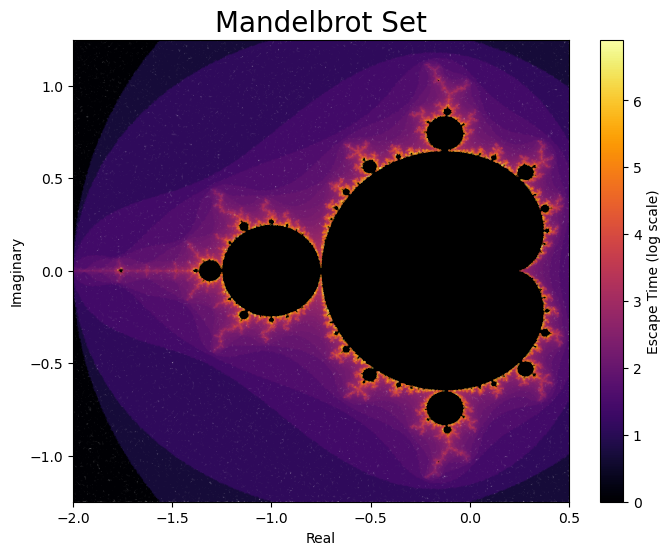

In [17]:
# Plot an example of the Mandelbrot set

# Parameters
n = 1000000
n_iter = 1000
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)

# Plot
fig, ax = plt.subplots(figsize=(8,6))

# Sampling and calculate the mandelbrot divergence in iteration number
sample = random_sample(n, x_range, y_range)
iterations = np.array([mandelbrot(point, n_iter) for point in sample])

# Separate points inside and outside the Mandelbrot set
in_set = iterations == n_iter
outside_set = ~in_set

# Use log-scaled colors for points outside the set
colors = np.log(iterations + 1)

# Plot on the provided axis
ax.scatter(sample[in_set].real, sample[in_set].imag, color='black', s=0.5, marker='.')
scatter = ax.scatter(sample[outside_set].real, sample[outside_set].imag,
                        c=colors[outside_set], cmap='inferno', s=0.1, marker='.')

# Set plot details
plt.xlim(x_range)
plt.ylim(y_range)
plt.title("Mandelbrot Set", fontsize=20)
plt.xlabel("Real")
plt.ylabel("Imaginary")

# Add a color bar to the last axis for escaping points
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', label="Escape Time (log scale)")

plt.savefig(os.path.join(lib_task_1, "example_of_mandelbrot_set.png"), dpi=500)
plt.show()


---
## 2a. Monte Carlo Integration Estimation

Estimate the area ( $A_M$ ) of the Mandelbrot set using Monte Carlo integration.
- Define a monte_carlo_area( ) function
- Accept sampling points and determine if each point belongs to the Mandelbrot set using iteration limits
- Calculate the area based on the proportion of points within the Mandelbrot set

**Functions**

In [62]:
# Pure Random Sampling
def monte_carlo_area_estimation(s: int, j: int, x_range: tuple, y_range: tuple, sampler: str) -> float:
    sample = random_sample(s, x_range, y_range, sampler)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) *(y_range[1] - y_range[0])


# Calculate the integral estimation for different iteration numbers smaller than the max iteration number
def calc_effect_of_number_iter(s: int, j_max: int, x_range: tuple, y_range: tuple, sampler: str, k: int = 100, start_j: int = 1) -> np.ndarray:
    if start_j * 0.5 > j_max:
        raise ValueError("Starting iteration number is too high.")
    iter_numbers = np.arange(start_j, j_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(s, actual_iter, x_range, y_range, sampler) for actual_iter in iter_numbers])
    return iter_numbers, area_estimations


# Calculate the integral estimation for different sample sizes
def calc_effect_of_sample_size(s_max: int, j: int, x_range: tuple, y_range: tuple, sampler: str, k: int, start_s: int) -> np.ndarray:
    if start_s * 0.5 > s_max:
        raise ValueError("Starting sample size is too high.")
    sample_sizes = np.arange(start_s, s_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(actual_sample_size, j, x_range, y_range, sampler) for actual_sample_size in sample_sizes])
    return sample_sizes, area_estimations


# Support functions
def is_in_mandelbrot(number: complex, iter_num: int) -> bool:
    return mandelbrot(number, iter_num) == iter_num

**Calculations**

In [20]:
# Calculate the area as n = 100000
s = 99856
j = 1000
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)

area_random = monte_carlo_area_estimation(s, j, x_range, y_range, "pure_random_sampling")
print("Estimated area using Pure Random Sampling:", area_random)

area_lhs = monte_carlo_area_estimation(s, j, x_range, y_range, "latin_hypercube_sampling")
print("Estimated area using Latin Hypercube Sampling:", area_lhs)

area_orthogonal = monte_carlo_area_estimation(s, j, x_range, y_range, "orthogonal_sampling")
print("Estimated area using Orthogonal Sampling:", area_orthogonal)

Estimated area using Pure Random Sampling: 1.511426454093895
Estimated area using Latin Hypercube Sampling: 1.4980321663195002
Estimated area using Orthogonal Sampling: 1.5090480291619934


**Plots**

In [ ]:
# Parameters
sample_size = 100000
max_iter = 1000
stepsize = 50
start_iter_n = 100
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
sampler = 'pure_random_sampling'
n_estimation_run = 5

true_area = 1.50659177

plt.figure(figsize=(8, 6))

# Create estimation plots
avg_area = []
for _ in range(n_estimation_run):
    iter_numbers, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
    plt.plot(iter_numbers, area_estimations, color="blue", linewidth=0.2, alpha=0.3)
    avg_area.append(area_estimations)

plt.plot(iter_numbers, avg_area[-1], color="blue", linewidth=0.2, alpha=0.3, label="Monte Carlo Integral Estimator")  # for the legend

# Plot the average
avg_area = np.average(np.array(avg_area), axis=0)
plt.plot(iter_numbers, avg_area, color="blue", linewidth=1, label="Average of the Estimations")

# Plot the true value for reference
plt.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75, label="Area of the Mandelbrot Set")

# Add details
plt.title("Monte Carlo Integral on Mandelbrot Set with Different Iteration Sizes", fontsize=20)
plt.xlabel("Number of Iterations")
plt.ylabel("Area Estimation")
plt.legend()

plt.tight_layout()

# Save and show
# plt.savefig(os.path.join(lib_task_2, "iteration_effect_pure_random_sampling.png"), dpi=500)
plt.show()


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

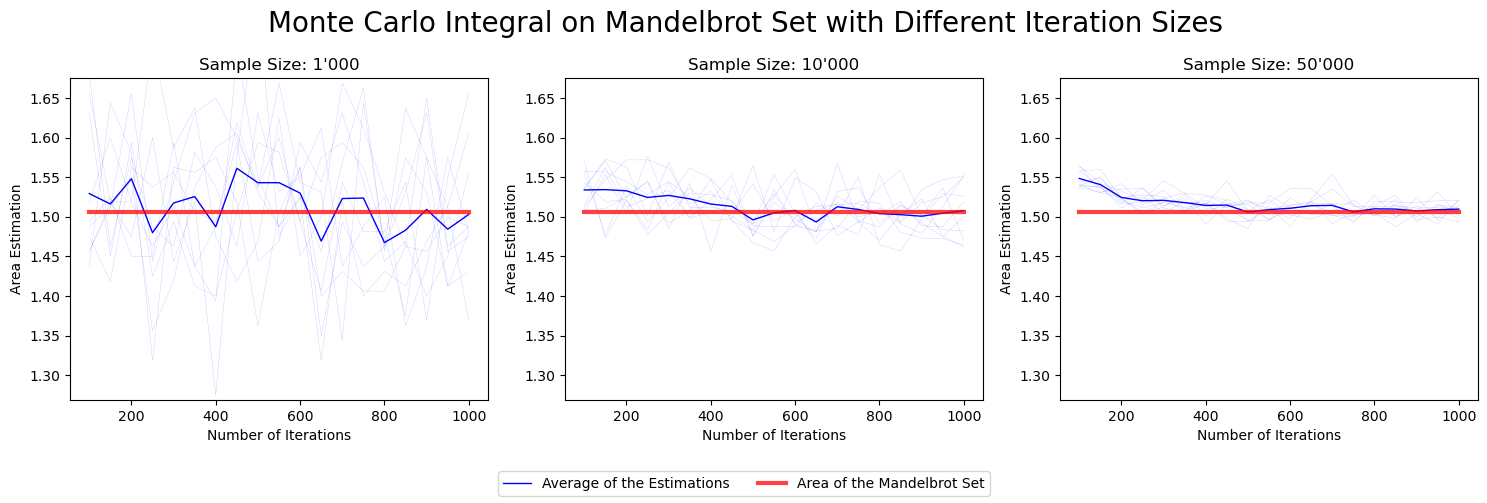

In [ ]:
# Parameters
max_iter = 1000
stepsize = 50
start_iter_n = 100
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
sampler = 'pure_random_sampling'
n_estimation_run = 10

true_area = 1.50659177

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sample_sizes = [1000, 10000, 50000]

# Initialize line objects for the legend
avg_line, true_line = None, None

# Find the minimum and maximum y-values for the first subplot
_, area_estimations = calc_effect_of_number_iter(sample_sizes[0], max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
y_min, y_max = min(area_estimations), max(area_estimations)

for i, sample_size in enumerate(sample_sizes):
    ax = axes[i]
    
    # Calculate the minimum and maximum y-values for the current subplot
    _, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
    subplot_y_min, subplot_y_max = min(area_estimations), max(area_estimations)
    
    # Adjust the y-axis limits to be the same as the first subplot
    y_min = min(y_min, subplot_y_min)
    y_max = max(y_max, subplot_y_max)
    
    avg_area = []
    for _ in range(n_estimation_run):
        iter_numbers, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
        ax.plot(iter_numbers, area_estimations, color="blue", linewidth=0.2, alpha=0.3)
        avg_area.append(area_estimations)

        print("check")
    
    avg_area = np.average(np.array(avg_area), axis=0)
    if avg_line is None:
        avg_line, = ax.plot(iter_numbers, avg_area, color="blue", linewidth=1, label="Average of the Estimations")
    else:
        ax.plot(iter_numbers, avg_area, color="blue", linewidth=1)
    
    if true_line is None:
        true_line, = ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75, label="Area of the Mandelbrot Set")
    else:
        ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75)
    
    ax.set_title(f"Sample Size: {sample_size:,}".replace(",", "'"))
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Area Estimation")
    
    # Set the same y-axis limits for all subplots
    ax.set_ylim(y_min, y_max)

    print(f"check {sample_size} DONE")

fig.suptitle("Monte Carlo Integral on Mandelbrot Set with Different Iteration Sizes", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)

# Add a single legend at the bottom
fig.legend([avg_line, true_line], ["Average of the Estimations", "Area of the Mandelbrot Set"], loc='lower center', ncol=2, frameon=True)

# Save and show
clear_output(wait=True)
plt.savefig(os.path.join(lib_task_2, "mult_sample_size_iteration_effect_pure_random_sampling.png"), dpi=500)
plt.show()



## 2b. Monte Carlo Integration Convergence

Estimate the area ( $A_M$ ) of the Mandelbrot set using Monte Carlo integration using the previously defined monte_carlo_area function.
Examine the speed of convergence and the accuracy of the estimation in two ways:
- First, see how the increase in the sample size, with a sufficiently large iteration number, results in a more and more accurate results
- Secondly see how for a fixed sample size the number of iteration determines the accuracy

**Plots**

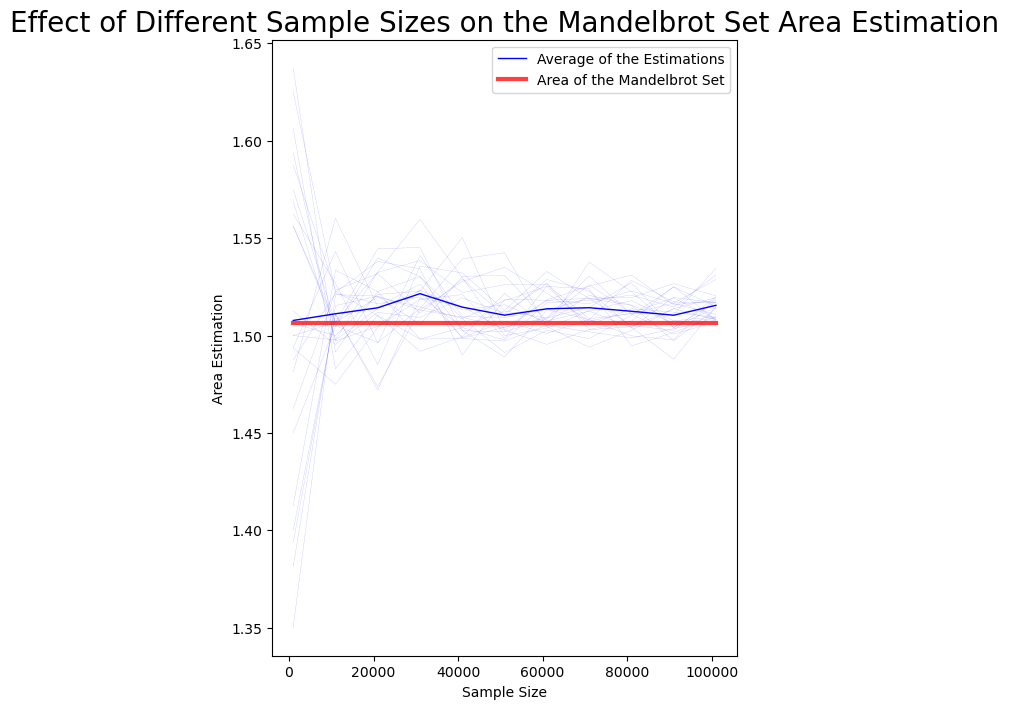

In [ ]:
# Effect of the sample size

# Parameters
max_sample_size = 1000000
j = 1000
stepsize = 10000
start_sample_size = 1000
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
sampler = 'pure_random_sampling'
n_estimation_run = 25

true_area = 1.50659177

plt.figure(figsize=(6, 8))

# Plot runs
avg_runs = []
for i in range(n_estimation_run):
    sample_sizes, area_estimations = calc_effect_of_sample_size(max_sample_size, j, x_range, y_range, sampler, stepsize, start_sample_size)
    plt.plot(sample_sizes, area_estimations, color='blue', linewidth=0.2, alpha=0.3)
    avg_runs.append(area_estimations)
    print(f"check {i}. run is done")

# Plot average
avg_runs = np.average(np.array(avg_runs), axis=0)
plt.plot(sample_sizes, avg_runs, color="blue", linewidth=1, label="Average of the Estimations")

# Plot true value for reference
plt.plot(sample_sizes, true_area * np.ones_like(sample_sizes), color="red", linewidth=3, alpha=0.75, label="Area of the Mandelbrot Set")

# Add figure details
plt.title("Effect of Different Sample Sizes on the Mandelbrot Set Area Estimation", fontsize=20)
plt.xlabel("Sample Size")
plt.ylabel("Area Estimation")
plt.legend()

# Save and plot the figure
clear_output(wait=True)
plt.savefig(os.path.join(lib_task_2, "effect_of_diff_sample_size_on_area.png"), dpi=500)
plt.show()



---
## 3. Experiment with Different Sampling Techniques


Examine the convergence and the accuracy of the estimation using the same methodology used in the previous (2b.) point using new sampling techniques:
- Latin Hypercube Sampling
- Orthogonal Sampling

**Plots**

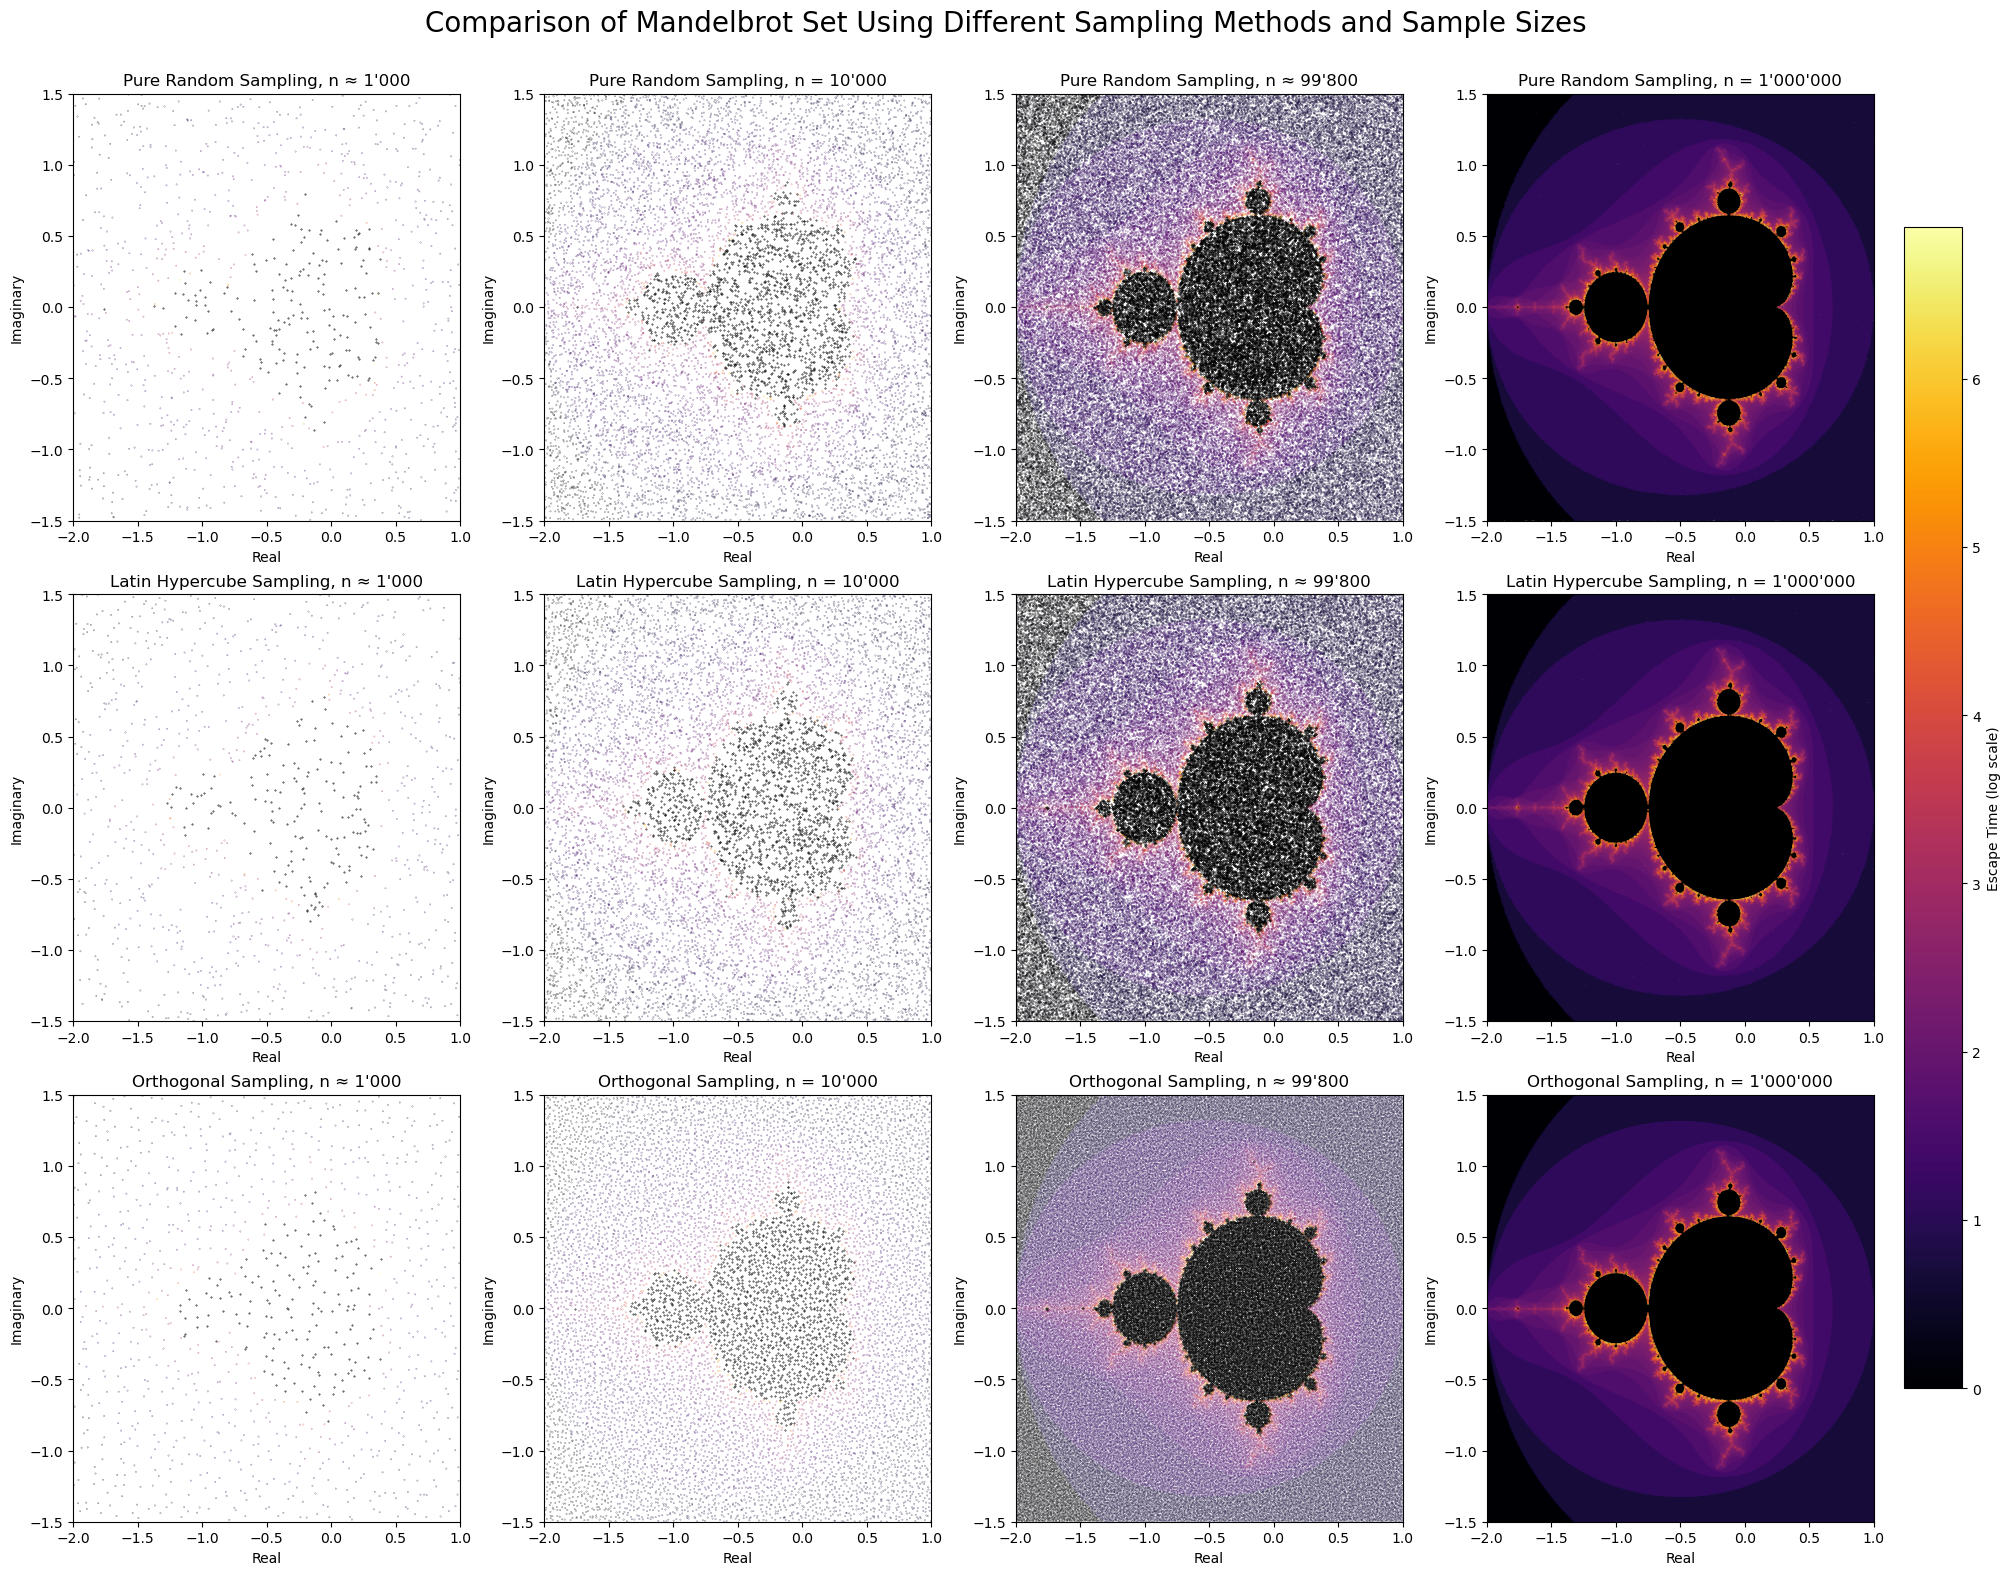

In [25]:
# Plotting the different types of sampling techniques for different sample size
def plot_mandelbrot_subfig(n=10000, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler='pure_random_sampling', ax=None):
    sample = random_sample(n, x_range, y_range, sampler)
    iterations = np.array([mandelbrot(point, max_iter) for point in sample])

    # Separate points inside and outside the Mandelbrot set
    in_set = iterations == max_iter
    outside_set = ~in_set

    # Use log-scaled colors for points outside the set
    colors = np.log(iterations + 1)

    # Plot on the provided axis
    ax.scatter(sample[in_set].real, sample[in_set].imag, color='black', s=0.5, marker='.')
    scatter = ax.scatter(sample[outside_set].real, sample[outside_set].imag,
                         c=colors[outside_set], cmap='inferno', s=0.1, marker='.')

    # Set plot details
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    sample_title = f"n = {n:,}".replace(',', "'")
    if n % 10 != 0:
        sample_title = f"n ≈ {int(int(n / 100) * 100):,}".replace(',', "'")
    ax.set_title(f"{sampler.replace('_', ' ').title()}, {sample_title}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    return scatter

# Set up the subplots for comparing different sampling methods and sample sizes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
fig.suptitle("Comparison of Mandelbrot Set Using Different Sampling Methods and Sample Sizes", fontsize=20, y=1.04)

# Define parameters
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
sample_sizes = [1024, 10000, 99856, 1000000]
# sample_sizes = [100, 121, 196, 400]  # for testing

# Plot for each sampler and sample size
for row, sampler in enumerate(samplers):
    for col, n in enumerate(sample_sizes):
        ax = axes[row, col]
        scatter = plot_mandelbrot_subfig(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler=sampler, ax=ax)
        print(f"check n = {n} done")
    print(f"check sampler = {sampler} done")

# Add a color bar to the last axis for escaping points
fig.colorbar(scatter, ax=axes[:, -1], orientation='vertical', label="Escape Time (log scale)")

clear_output(wait=True)
plt.savefig(os.path.join(lib_task_3, "mandelbrot_pic_with_diff_sampling.png"), dpi=500)
plt.show()

---
## 4. Estimation Improvement

- Come up with a new improved way to estimate the area of the Mandelbrot set.
- Examine the convergence pace and the accuracy of the new estimator algorithm compared to the previous ones

**Functions**